# prepare dataset and libraries

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('C:\\Users\\Saeth\\Downloads\\WIC_Dev_V1.csv')

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
from ax import optimize

In [17]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import math
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import tagset_mapping, map_tag
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
from sklearn.decomposition import PCA
import random
import warnings
warnings.filterwarnings("ignore") 

In [6]:
maxy = max(data['freq'])
maxy

1461750

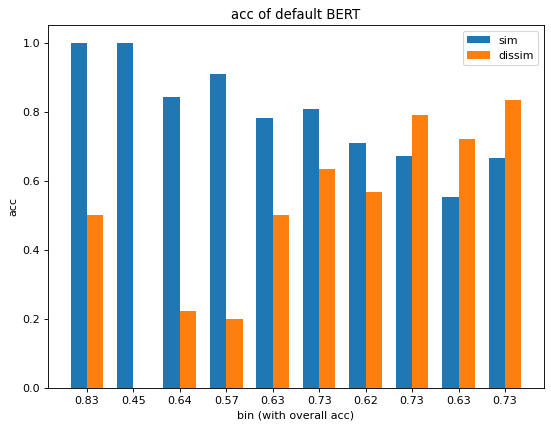

overall acc:  0.6666666666666666


In [21]:
# baseline
no_bin=10
# 3399860
# 3895208
move = np.log2(maxy)/no_bin
rec= {i+1:[0,0,0,0] for i in range(10)}

score = 0
for index in range(len(data)):
    emb1 = torch.tensor([float(i) for i in data.iloc[index]['emb1'][1:-2].split(',')])
    emb2 = torch.tensor([float(i) for i in data.iloc[index]['emb2'][1:-2].split(',')])
    log2_freq = data.iloc[index]['log2freq']
    cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2)))

    if cos >= 0.5447465400847086:
        temp = 'T'
    else:
        temp = 'F'
    lol=False
    label = data.iloc[index]['human_label']
    if temp == label:
        score+=1
        lol=True
    for j in range(10):
        left = j*move
        if log2_freq<left:
            if label == 'T':
                rec[j][1]+=1
                if lol:
                    rec[j][0]+=1
            else:
                rec[j][3]+=1
                if lol:
                    rec[j][2]+=1
            break
        if j==9:
            if label == 'T':
                rec[j+1][1]+=1
                if lol:
                    rec[j+1][0]+=1
            else:
                rec[j+1][3]+=1
                if lol:
                    rec[j+1][2]+=1
#print(rec)
figure(figsize=(8, 6), dpi=80)
N = 10
#men_means = (20, 35, 30, 35, 27)
#women_means = (25, 32, 34, 20, 25)
x=[j for j in range(1,11)]
ind = np.arange(N) 
width = 0.35
y=[]
for g in list(rec.values()):
    if g[1] != 0:
        y.append(g[0]/g[1])
    else:
        y.append(0)
plt.bar(ind, y, width, label='sim')
y2=[]
for h in  list(rec.values()):
    if h[3] !=0:
        y2.append(h[2]/h[3])
    else:
        y2.append(0)
plt.bar(ind + width, y2, width,
    label='dissim')

#plt.bar(ind + 2*width, [(h[0]+h[2])/(h[3]+h[1]) for h in list(rec.values())], width,
    #label='overall')

plt.ylabel('acc')
plt.xlabel('bin (with overall acc)')
plt.title('acc of default BERT')

y3=[]
for h in list(rec.values()):
    if h[3]+h[1] != 0:
        y3.append((h[0]+h[2])/(h[3]+h[1]))
    else:
        y3.append(0)
default_result = ["{:.2f}".format(k) for k in y3]

plt.xticks(ind + width/2, default_result)
plt.legend(loc='best')
plt.show()


print('overall acc: ', score/len(data))

# test results

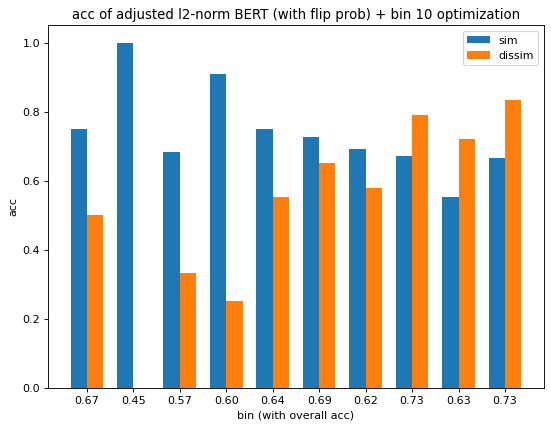

overall acc:  0.6571428571428571


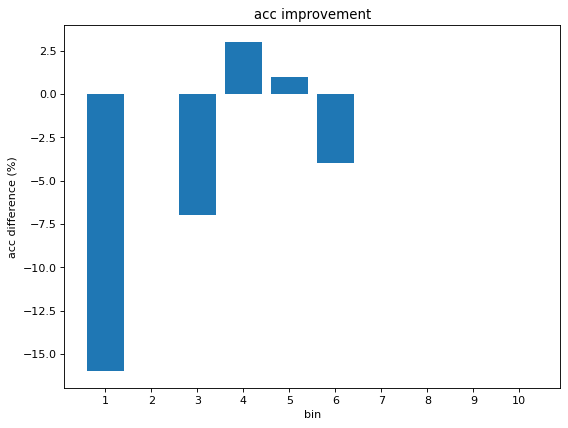

In [177]:
# alpha = -0.01* bin + 1.06

no_bin=10
# 3399860
# 3895208
move = np.log2(maxy)/no_bin
rec= {i+1:[0,0,0,0] for i in range(10)}
m1 = 0.025
t1 = 14
score = 0
for index in range(len(data)):
    emb1 = torch.tensor([float(i) for i in data.iloc[index]['emb1'][1:-2].split(',')])
    emb2 = torch.tensor([float(i) for i in data.iloc[index]['emb2'][1:-2].split(',')])
    log2_freq = data.iloc[index]['log2freq']
    cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2)))
    if log2_freq<= t1:
        if (data.iloc[index]['keyword'] not in gensim.parsing.preprocessing.STOPWORDS) and data.iloc[index]['POS']=='N':
            alpha = (-m1* log2_freq) + 1 + t1*m1
            # non_stop words m1 lowest
            cos = np.dot(emb1, emb2)/((np.linalg.norm(emb1)*np.linalg.norm(emb2))*alpha)
    if cos >= 0.5447465400847086:
        temp = 'T'
    else:
        temp = 'F'
    lol=False
    label = data.iloc[index]['human_label']
    if temp == label:
        score+=1
        lol=True
    for j in range(10):
        left = j*move
        if log2_freq<left:
            if label == 'T':
                rec[j][1]+=1
                if lol:
                    rec[j][0]+=1
            else:
                rec[j][3]+=1
                if lol:
                    rec[j][2]+=1
            break
        if j==9:
            if label == 'T':
                rec[j+1][1]+=1
                if lol:
                    rec[j+1][0]+=1
            else:
                rec[j+1][3]+=1
                if lol:
                    rec[j+1][2]+=1

figure(figsize=(8, 6), dpi=80)
N = 10
#men_means = (20, 35, 30, 35, 27)
#women_means = (25, 32, 34, 20, 25)
x=[j for j in range(1,11)]
ind = np.arange(N) 
width = 0.35     
plt.bar(ind, [g[0]/g[1] for g in list(rec.values())], width, label='sim')
plt.bar(ind + width, [h[2]/h[3] for h in list(rec.values())], width,
    label='dissim')

#plt.bar(ind + 2*width, [(h[0]+h[2])/(h[3]+h[1]) for h in list(rec.values())], width,
    #label='overall')

plt.ylabel('acc')
plt.xlabel('bin (with overall acc)')
plt.title('acc of adjusted l2-norm BERT (with flip prob) + bin 10 optimization')

y = ["{:.2f}".format((h[0]+h[2])/(h[3]+h[1])) for h in list(rec.values())]
plt.xticks(ind + width/2, y)
plt.legend(loc='best')
plt.show()


print('overall acc: ', score/len(data))

figure(figsize=(8, 6), dpi=80)
y2=[]
for i in range(len(default_result)):
    y2.append((float(y[i]) - float(default_result[i]))*100)
#print(y2)
plt.bar(x, y2)
plt.xlabel('bin')
plt.ylabel('acc difference (%)')
plt.title('acc improvement')
plt.xticks(x)
plt.show()